In [20]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install jupyter
!pip install --upgrade qiskit qiskit-aer matplotlib
!pip install qiskit-aer


In [31]:
# Cell 2: Imports and Simulator Setup
%matplotlib inline

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

simulator = AerSimulator()



In [36]:
from qiskit.quantum_info import Operator
from qiskit.circuit.library import IGate, XGate, CXGate

# Define basic operators
I    = Operator(IGate())
X    = Operator(XGate())
CX_1 = Operator(CXGate(ctrl_state=1))
CX_0 = Operator(CXGate(ctrl_state=0))

# Four 3-input oracles + ancilla
U_list = [
    Operator(I ^ I ^ I ^ I),    # constant-0
    Operator(CX_1 ^ I ^ I),      # balanced (ctrl_state=1)
    Operator(X ^ I ^ I ^ I),     # constant-1
    Operator(CX_0 ^ I ^ I)       # balanced (ctrl_state=0)
]

def deutsch_jozsa_circuit(U: Operator) -> QuantumCircuit:
    x = QuantumRegister(3, 'x')
    y = QuantumRegister(1, 'y')
    z = ClassicalRegister(3, 'z')
    qc = QuantumCircuit(x, y, z, name='Deutsch–Jozsa')

    qc.x(y)
    qc.h(x[:] + y[:])
    qc.barrier()

    U_inst = U.to_instruction()
    qc.unitary(U_inst, x[:] + y[:], label='U_f')
    qc.barrier()

    qc.h(x)
    qc.measure(x, z)
    return qc


In [37]:
shots      = 1024
all_counts = []
decisions  = []

for idx, U in enumerate(U_list, start=1):
    qc     = deutsch_jozsa_circuit(U)
    qc_t   = transpile(qc, simulator)
    job    = simulator.run(qc_t, shots=shots)
    counts = job.result().get_counts(qc_t)
    all_counts.append(counts)

    verdict = 'constant' if counts.get('000', 0) == shots else 'balanced'
    decisions.append((idx, verdict))

for idx, verdict in decisions:
    print(f"Oracle {idx} decision: {verdict}")
    print(f"Counts: {all_counts[idx-1]}\n")


Oracle 1 decision: constant
Counts: {'000': 1024}

Oracle 2 decision: balanced
Counts: {'100': 1024}

Oracle 3 decision: constant
Counts: {'000': 1024}

Oracle 4 decision: balanced
Counts: {'100': 1024}



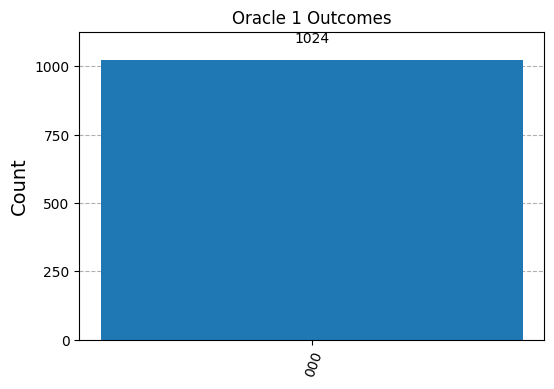

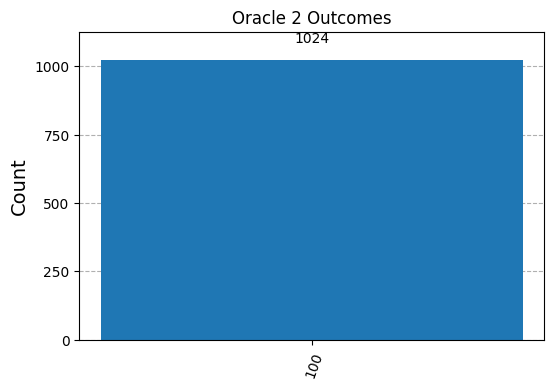

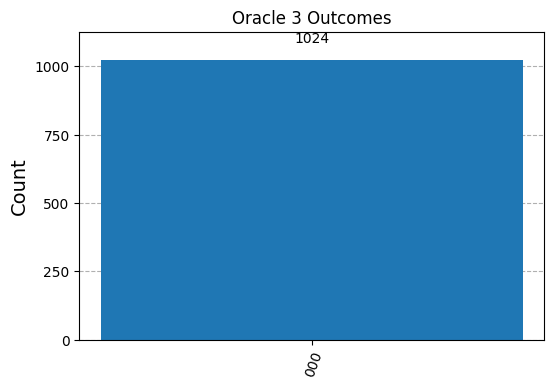

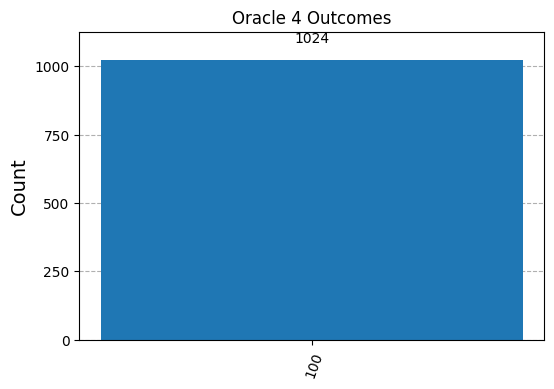

In [38]:
for idx, counts in enumerate(all_counts, start=1):
    fig, ax = plt.subplots(figsize=(6, 4))
    plot_histogram(counts, ax=ax, title=f"Oracle {idx} Outcomes")
    plt.show()
